# Machine Characteristics and Efficiency Maps

Machine characteristics such as speed, torque, voltage, currents, frequency etc. can be efficiently calculated by equivalent circuit models which are included in the module 'femagtools.machine':

In [1]:
import femagtools.machine
import logging
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(message)s')
p = 4
r1 = 0.0806
ls = 0.0
ld = [0.0014522728, 0.0014522728]
lq = [0.0038278836, 0.0032154]
psim = [0.11171972, 0.11171972]
i1 = [80.0]
beta = [-41.1, 0]

pm = femagtools.machine.PmRelMachineLdq(3, p, psim, ld, lq, r1, beta, i1, ls)

2024-01-05 14:47:56,628 loss map missing: 'losses'


Note: The warning message can be ignored. It indicates that the loss values are missing.

For example we can calculate the iq and id current for a given torque of 170 Nm:

In [2]:
pm.iqd_torque(170)

array([ 87.16183677, -71.16227683])

Or reversely: we calculate the torque with given id, iq current:

In [3]:
pm.torque_iqd(87.16183261, -71.16228193)

169.9999999732831

For the transformation of i1-beta and id-iq components there are corresponding functions:

In [4]:
femagtools.machine.betai1(87.16, -71.16)

(-0.6846789860301091, 79.56321763227024)

In [5]:
femagtools.machine.iqd(-0.685, 79.56)

array([ 87.13362822, -71.18509698])

Show the torque vs beta curve:

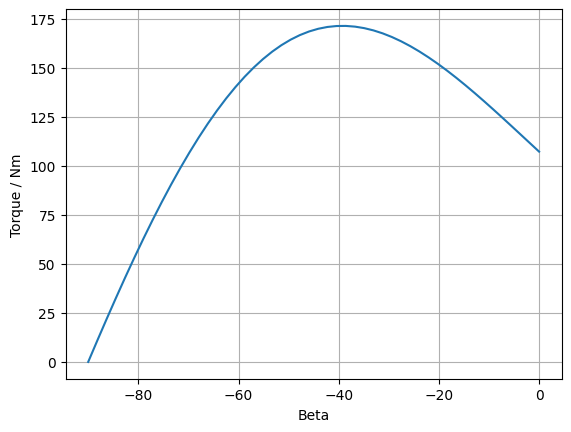

In [6]:
import matplotlib.pyplot as plt
import numpy as np

i1max = 80
beta=np.linspace(-np.pi/2, 0)
plt.plot(180*beta/np.pi, [pm.torque_iqd(*femagtools.machine.iqd(b, i1max)) 
                          for b in beta])
plt.xlabel('Beta')
plt.ylabel('Torque / Nm')
plt.grid()

The maximum torque of i1 max:

In [7]:
pm.torquemax(i1max)

171.4091046999536

Calculate the amplitude of the phase voltage at frequency 75 Hz:

In [8]:
f1 = 75
w1 = 2*np.pi*f1
np.linalg.norm(pm.uqd(w1, 87.16183261, -71.16228193))

165.10379403723468

Find the frequency from maximum torque and voltage:

In [9]:
Tmax = 170
u1 = 230.0

w1 = pm.w1_umax(u1, *pm.iqd_torque(Tmax))
print("Frequency {}".format(w1/np.pi/2))

Frequency 150.96101553644635


Plot the speed torque characteristics:

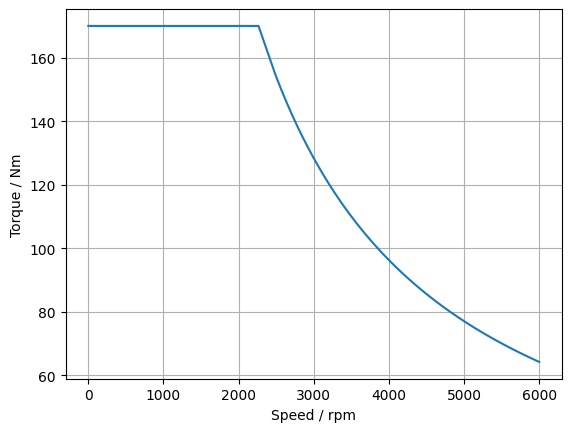

In [10]:
def torque(T, pmax, wm):
    """shaft torque as a function of rotor angular speed"""
    if wm <= pmax / T:
        return T
    return pmax / wm

nmax = 6000/60
pmax = w1/p*Tmax
n = np.append(np.linspace(0, w1/2/np.pi/p),
              np.linspace(1.1*w1/2/np.pi/p, nmax))

plt.plot(60*n, [torque(Tmax, pmax, 2*np.pi*nx) for nx in n])
plt.ylabel('Torque / Nm')
plt.xlabel('Speed / rpm')
plt.grid()

Show the speed characterstics plot with the motor parameters from a Ld-Lq-Identification:

In [11]:
bch = femagtools.read_bchfile('femag/LDQ-0-90.BCH')
pm = femagtools.machine.create(bch, r1 = 0.05, ls = 0)
Tmax = 500
char = pm.characteristics(Tmax, n=6000/60, u1max=230, with_pmconst=False, with_torque_corr=True)

2024-01-05 14:47:57,065 ld-lq 5 x 7
2024-01-05 14:47:57,066 Stator Subregions: ['StYoke', 'StTeeth', 'Rotor', 'mag']
2024-01-05 14:47:57,067 losses for speed 50.000000
2024-01-05 14:47:57,451 loss map missing: 'speed'
2024-01-05 14:47:57,734 corrected torque: 500 -> 399.0 Nm
2024-01-05 14:47:57,817 Type speed 1815.0870 n: 6000.0000 nmax 6000.0 T 399.0 i1max 199.9
2024-01-05 14:47:58,552 Speedrange T=399 Nm [0, 30.251449815191954, 34.54975517066839, 100.0]
2024-01-05 14:47:58,552 sample intervals [18, 2, 39]
2024-01-05 14:47:58,563 RANGE MTPA 2: 32.400602 -- 34.549755
2024-01-05 14:47:58,566 RANGE MTPV 39: 36.227967 -- 100.000000


Note that the torque value has been corrected as it was too high for the simulated psid/psiq maps.

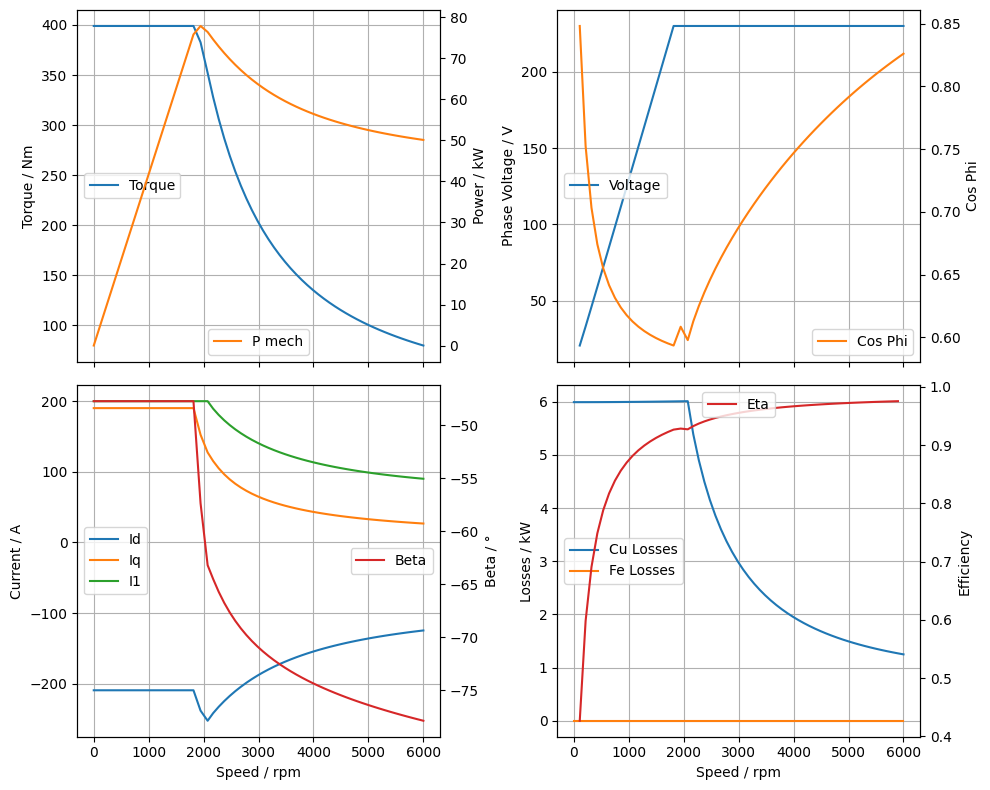

In [12]:
import femagtools.plot
fig = femagtools.plot.characteristics(char)

Note that the loss values are zero due to the missing core loss parameters.

Another option is to create an individual plot:

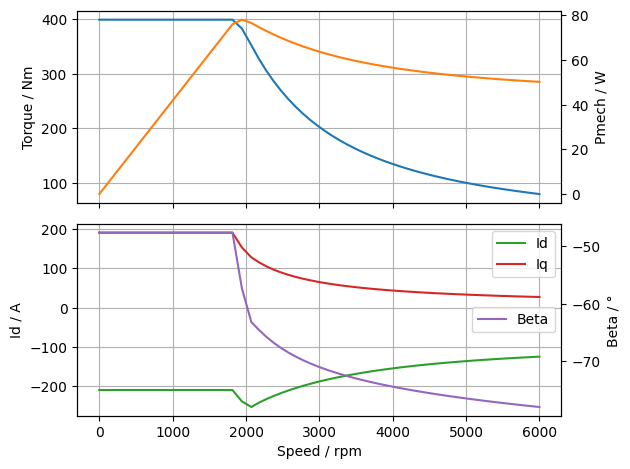

In [13]:
fig, axs = plt.subplots(nrows=2, sharex=True)
speed = 60 * np.array(char['n'])
axs[0].plot(speed, char['T'], color='C0')
ax1 = axs[0].twinx()
ax1.plot(speed, [1e-3*p for p in char['pmech']], color='C1')
axs[0].grid()
axs[0].set_ylabel('Torque / Nm')
ax1.set_ylabel('Pmech / W')
axs[1].plot(speed, char['id'], color='C2', label='Id')
axs[1].plot(speed, char['iq'], color='C3', label='Iq')
axs[1].legend()
ax2 = axs[1].twinx()
ax2.set_ylabel('Beta / °')
ax2.plot(speed, char['beta'], color='C4', label='Beta')
ax2.legend(loc='center right')
axs[1].grid()
axs[1].set_xlabel('Speed / rpm')
axs[1].set_ylabel('Id / A')
fig.tight_layout()

Display the characteristics with a MTPA Plot:

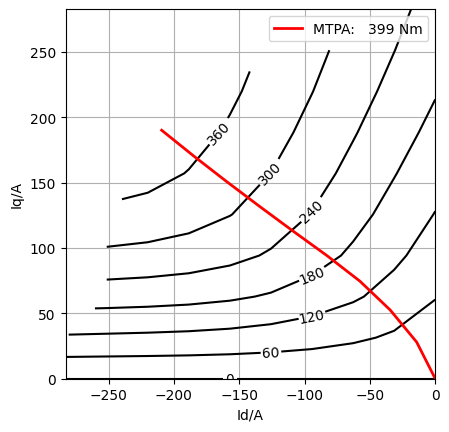

In [14]:
femagtools.plot.mtpa(pm, bch.ldq['i1'][-1])

The same current-torque characteristics as a surface plot

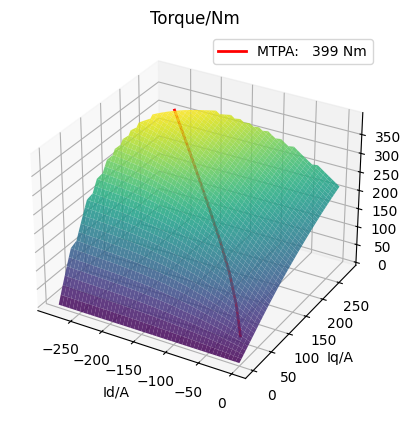

In [15]:
femagtools.plot.mtpa(pm, bch.ldq['i1'][-1], projection='3d')
plt.show()

## Efficiency Map

Let's calculate the efficiency map with reduced torque:

In [16]:
import femagtools.machine.effloss
temp = []
Tmax = 200
u1max = 230
effmap = femagtools.machine.effloss.efficiency_losses_map(
    pm, u1max, Tmax, temp, nmax, with_tmech=False, with_pmconst=False)

2024-01-05 14:48:00,237 Type speed 2221.3538 n: 6000.0000 nmax 6000.0 T 200.0 i1max 92.2
2024-01-05 14:48:00,395 Speedrange T=200 Nm [0, 37.02274429255362, 95.35073685735536, 100.0]
2024-01-05 14:48:00,395 sample intervals [22, 34, 2]
2024-01-05 14:48:00,407 RANGE MTPA 34: 38.738098 -- 95.350737
2024-01-05 14:48:00,444 RANGE MTPV 2: 97.675368 -- 100.000000
2024-01-05 14:48:00,460 total speed,torque samples 1856
2024-01-05 14:48:00,976 Losses/Eff Map: 7%
2024-01-05 14:48:01,495 Losses/Eff Map: 13%
2024-01-05 14:48:02,090 Losses/Eff Map: 20%
2024-01-05 14:48:02,744 Losses/Eff Map: 27%
2024-01-05 14:48:03,369 Losses/Eff Map: 33%
2024-01-05 14:48:03,956 Losses/Eff Map: 40%
2024-01-05 14:48:04,572 Losses/Eff Map: 47%
2024-01-05 14:48:05,355 Losses/Eff Map: 53%
2024-01-05 14:48:06,360 Losses/Eff Map: 60%
2024-01-05 14:48:07,450 Losses/Eff Map: 67%
2024-01-05 14:48:08,400 Losses/Eff Map: 73%
2024-01-05 14:48:09,261 Losses/Eff Map: 80%
2024-01-05 14:48:10,136 Losses/Eff Map: 87%
2024-01-05 14:

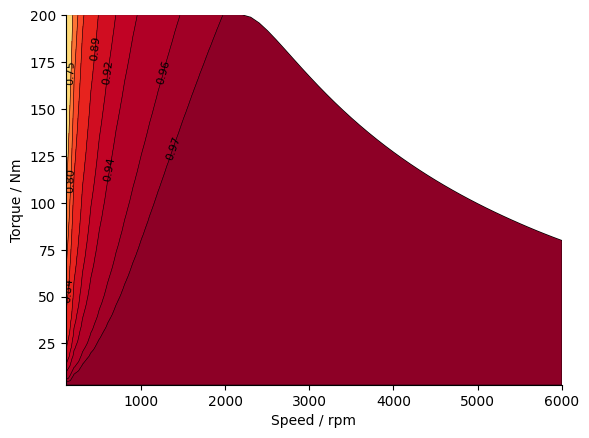

In [17]:
fig, ax = plt.subplots()
cfg = femagtools.plot.efficiency_map(effmap, ax, title='')

## Using an ERG File

The equivalent model can be created with parameters from a ERG file as well:

In [25]:
import femagtools.erg
erg = femagtools.erg.read('femag/ldlq.erg')
pmerg = femagtools.machine.create(erg, r1 = 0, ls = 0, lfe=350)
Tmax = 9500
nmax = 600/60
u1max = 500/np.sqrt(3)
char = pmerg.characteristics(Tmax, n=nmax, u1max=u1max, with_pmconst=False, with_tmech=False)

2024-01-05 14:49:00,335 loss map missing: 'losses'
2024-01-05 14:49:00,347 Type speed 302.9733 n: 600.0000 nmax 600.0 T 9500.0 i1max 732.8
2024-01-05 14:49:00,421 Speedrange T=9500 Nm [0, 5.04953248036756, 7.191648401892814]
2024-01-05 14:49:00,422 sample intervals [42, 17]
2024-01-05 14:49:00,440 RANGE MTPA 17: 5.175561 -- 7.191648


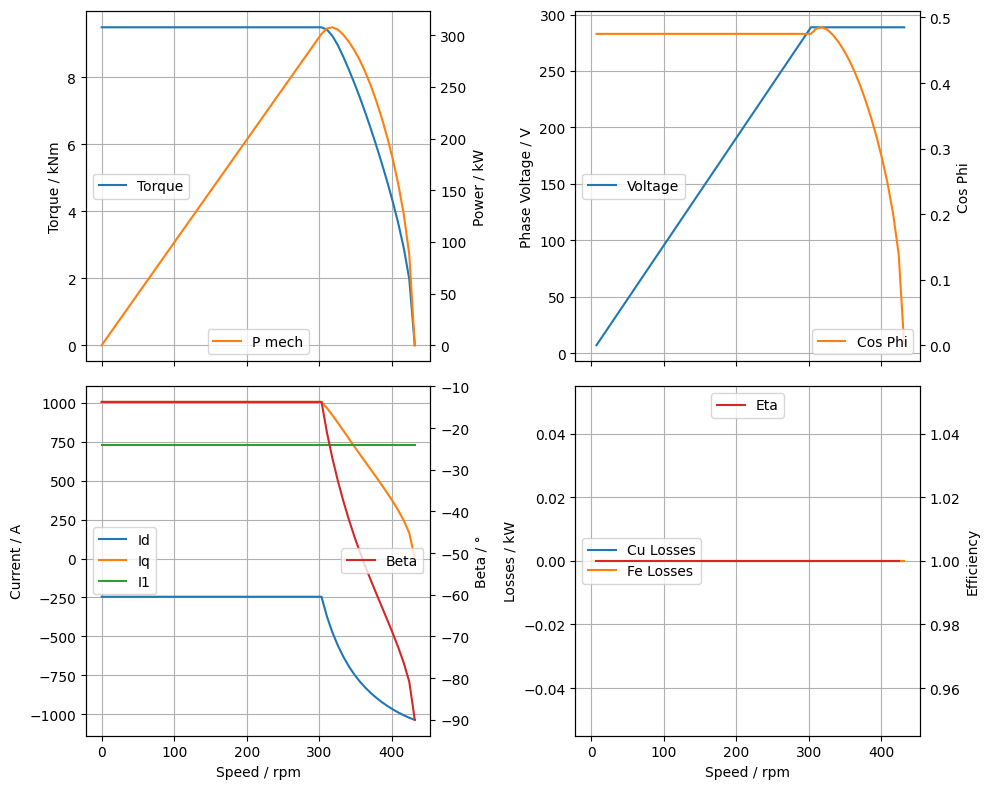

In [26]:
fig = femagtools.plot.characteristics(char)

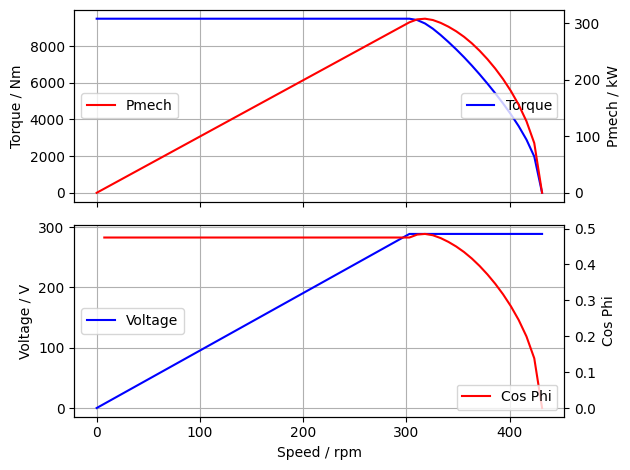

In [27]:
n = 60*np.array(char['n'])
fig, axs = plt.subplots(2, sharex=True)

axs[0].plot(n, char['T'], 'b-', label='Torque')
axs[0].set_ylabel("Torque / Nm")
axs[0].grid()
axs[0].legend(loc='center right')
ax2 = axs[0].twinx()
ax2.plot(n, 1e-3*np.array(char['pmech']), 'r-', label='Pmech')
ax2.set_ylabel("Pmech / kW")
ax2.legend(loc='center left')

axs[1].plot(n, char['u1'], 'b-', label='Voltage')
axs[1].set_ylabel("Voltage / V",)
axs[1].set_xlabel("Speed / rpm")
axs[1].grid()
axs[1].legend(loc='center left')
ax3 = axs[1].twinx()
ax3.plot(n[1:], char['cosphi'][1:], 'r-', label='Cos Phi')
ax3.set_ylabel("Cos Phi")
ax3.legend(loc='lower right')

fig.tight_layout()